# Correlation Study

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("no issue")

no issue


In [43]:
df_merged = pd.read_csv('Data/edited data/merged_data.csv')
df_merged = df_merged.astype(float)

### Pairwise Correlation

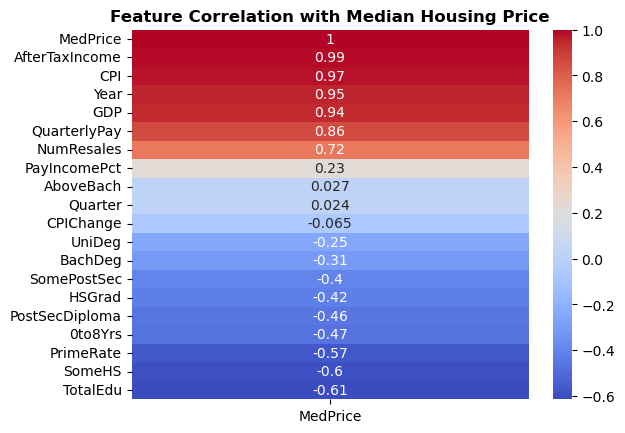

In [44]:
rename_dict = { # rename for readability
    'YEAR': 'Year',
    'GDMPBC': 'GDP',
    'Total, all education levels': 'TotalEdu',
    '0 to 8  years 8': '0to8Yrs',
    'Some high school 9': 'SomeHS',
    'High school graduate 10': 'HSGrad',
    'Some postsecondary 11': 'SomePostSec',
    'Postsecondary certificate or diploma 12': 'PostSecDiploma',
    'University degree 13': 'UniDeg',
    "Bachelor's degree": 'BachDeg',
    "Above bachelor's degree": 'AboveBach',
    'All Items Index': 'CPI',
    'Annual Percent Change': 'CPIChange',
    'QUARTER': 'Quarter',
    'HOUSING TYPE': 'HouseType',
    'MEDIAN HOUSING PRICE': 'MedPrice',
    'MEDIAN AFTER TAX FAMILY INCOME': 'AfterTaxIncome',
    'PRIME INTEREST RATE': 'PrimeRate',
    'QUARTERLY PAYMENT': 'QuarterlyPay',
    'PAYMENT TO INCOME PERCENT': 'PayIncomePct',
    'NUMBER OF RESALES': 'NumResales'
}

corr = df_merged.corr(numeric_only=True)

sns.heatmap(
    corr[['MEDIAN HOUSING PRICE']].sort_values(by='MEDIAN HOUSING PRICE', ascending=False).rename(index=rename_dict, columns=rename_dict),
    annot=True,
    cmap='coolwarm'
)

plt.title(
    "Feature Correlation with Median Housing Price",
    fontweight='bold'
)
plt.savefig("Output/hm-fc")
plt.show()

Multicollinearity (checking for redundancy)

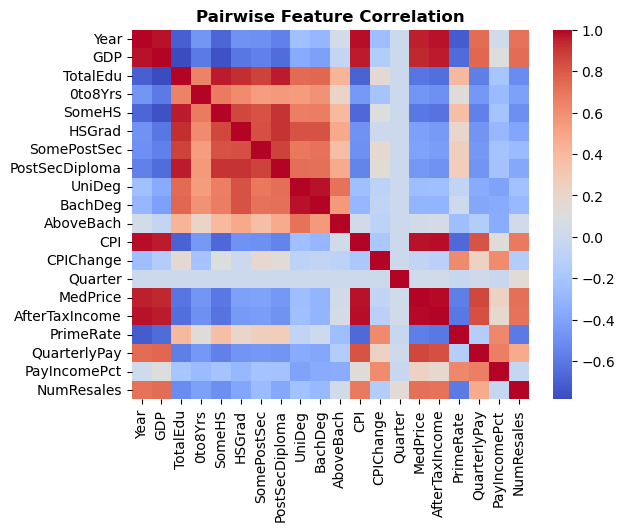

In [45]:
sns.heatmap(
    corr.rename(index=rename_dict, columns=rename_dict),
    cmap='coolwarm'
)

plt.title(
    "Pairwise Feature Correlation",
    fontweight='bold'
)
plt.savefig("Output/hm-pw")
plt.show()

Filter out features

In [46]:
s = 0
if s:
    # leave out strong feats
    tgt_corr = corr['MEDIAN HOUSING PRICE']
    stgt_corr_idx = list(set(list(tgt_corr[abs(tgt_corr) < 0.9].index) + ['YEAR', 'MEDIAN HOUSING PRICE', 'QUARTER']))
else:
    # leave out weak feats
    tgt_corr = corr['MEDIAN HOUSING PRICE']
    stgt_corr_idx = list(set(list(tgt_corr[abs(tgt_corr) > 0.05].index) + ['YEAR', 'MEDIAN HOUSING PRICE', 'QUARTER']))

print(df_merged[stgt_corr_idx].iloc[0])


University degree 13                            4.300000
0 to 8  years 8                                10.500000
Bachelor's degree                               4.600000
Some postsecondary 11                           8.800000
QUARTER                                         1.000000
PAYMENT TO INCOME PERCENT                      53.137276
All Items Index                                78.400000
NUMBER OF RESALES                            9617.000000
Some high school 9                             12.900000
YEAR                                         1990.000000
High school graduate 10                         6.700000
MEDIAN AFTER TAX FAMILY INCOME              37138.510090
Annual Percent Change                           5.400000
MEDIAN HOUSING PRICE                       147500.000000
Total, all education levels                     7.400000
Postsecondary certificate or diploma 12         6.200000
PRIME INTEREST RATE                            13.846154
QUARTERLY PAYMENT              

In [47]:
'GDMPBC', 'QUARTERLY PAYMENT', 'NUMBER OF RESALES', 'MEDIAN AFTER TAX FAMILY INCOME'
'Postsecondary certificate or diploma 12', '0 to 8  years 8', 'University degree 13', 'Some high school 9', "Bachelor's degree", 'Some postsecondary 11', 'High school graduate 10'

('Postsecondary certificate or diploma 12',
 '0 to 8  years 8',
 'University degree 13',
 'Some high school 9',
 "Bachelor's degree",
 'Some postsecondary 11',
 'High school graduate 10')

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_filt = df_merged[stgt_corr_idx].copy().drop(columns=[])
df_filt_train = df_filt[df_filt['YEAR'] <= 2018]
df_filt_test = df_filt[df_filt['YEAR'] > 2018]

X_train = df_filt_train.drop(columns=["MEDIAN HOUSING PRICE"])
Y_train = df_filt_train["MEDIAN HOUSING PRICE"]
X_test = df_filt_test.drop(columns=["MEDIAN HOUSING PRICE"])
Y_test = df_filt_test["MEDIAN HOUSING PRICE"]

LR_model = LinearRegression()
LR_model.fit(X_train, Y_train)
Y_pred = LR_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

coef_label = pd.DataFrame({
    'Feats': X_test.columns,
    'Coefs': LR_model.coef_
})
print(coef_label.sort_values(by=['Coefs']))

print(f'Mean Squared Error: {mse:.2f}, Sqrt MSE: {np.sqrt(mse):.2f}')
print(f'R^2 Score: {r2:.2f}')

                                      Feats         Coefs
15                      PRIME INTEREST RATE -22656.936942
14  Postsecondary certificate or diploma 12  -9384.215929
2                         Bachelor's degree  -8347.171547
0                      University degree 13  -4485.214376
3                     Some postsecondary 11   -765.038459
1                           0 to 8  years 8   -549.364696
4                                   QUARTER   -524.617892
17                                   GDMPBC     -4.091740
16                        QUARTERLY PAYMENT     -0.412977
7                         NUMBER OF RESALES      0.461522
11           MEDIAN AFTER TAX FAMILY INCOME      6.669116
6                           All Items Index   1663.694566
9                                      YEAR   1972.090986
8                        Some high school 9   3076.219439
12                    Annual Percent Change   6959.003947
10                  High school graduate 10   7703.090106
5             

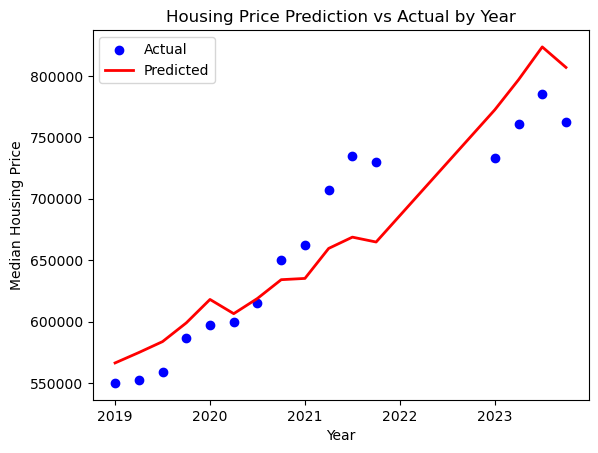

In [49]:
# merge year and quarter into a single feature for plot
df_filt_test.loc[:, 'YEAR'] = df_filt_test['YEAR'] + (df_filt_test['QUARTER'] - 1) * 0.25
df_test = df_filt_test.drop(columns=['QUARTER'])

# plot for actual values & predicted values
plt.scatter(df_test['YEAR'], df_test['MEDIAN HOUSING PRICE'], color='blue', label='Actual')
plt.plot(df_test['YEAR'], Y_pred, color='red', linewidth=2, label='Predicted')

plt.xlabel('Year')
plt.ylabel('Median Housing Price')
plt.title('Housing Price Prediction vs Actual by Year')
plt.legend()
plt.show()